# Домашнее задание №1

Темы "Введение в МатСтат" и "Виды статистических оценок и характеристики"

Общие положения:
- Макс кол-во баллов за ДЗ - 25 баллов
- Качество оформления и кода играет роль

Список заданий:
1. Посчитайте кол-во уникальных жанров. (1 балл)
2. Посчитайте и визуализируйте средний рейтинг и стандартное отклонение по типу аниме `type`. (1 балл)
3. Посчитайте и визуализируйте средний рейтинг и стандартное отклонение по жанрам `genre`. (1 балл)
4. Посчитайте и визуализируйте квартили Q1, Q2 и Q3 с интерквантильным размахом по жанрам `genre` и типу аниме `type`. (1 балл)
5. Насколько часто встречаются аниме с одним или двумя жанрами? (1 балл)
6. Сколько в среднем эпизодов приходится на аниме типа == `TV`? (1 балл)
7. По правилу трех сигм на столбцах `episodes`, `rating` и `members` оцените кол-во аномалий. (1 балл)
  - если по одному из столбцов аниме не попадает в интервал трех сигм, то оно считается аномальным
8. Оцените и визуализируйте корреляцию среднего рейтинга жанра со средними кол-вом эпизодов и кол-вом подписчиков. (1 балл)
9. Оцените и визуализируйте корреляцию кол-ва жанров у аниме с его рейтингом и кол-вом подписчиков по каждому типу аниме `type`. (1 балл)
10. Оцените и визуализируйте корреляцию длины названия аниме `name` с его рейтингом, кол-вом жанров, эпизодов и подписчиков. (1 балл)



In [2]:
import numpy as np
import pandas as pd

# Не обязательно, можно использовать любую удобную вам библиотеку для визуализации
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
%matplotlib inline

In [3]:
!curl -O https://raw.githubusercontent.com/practical-jupyter/sample-data/refs/heads/master/anime/anime.csv >> anime.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  778k  100  778k    0     0   873k      0 --:--:-- --:--:-- --:--:--  873k


Описание датафрейма:
- `anime_id` - ID
- `name` - название
- `genre` - жанр (строка с пречисление через запятую)
- `type` - формат
- `episodes` - кол-во эпизодов
- `rating` - средний рейтинг
- `members` - кол-во смотрящих

In [74]:
raw_df = pd.read_csv('anime.csv')
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10486 entries, 0 to 10485
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  10486 non-null  int64  
 1   name      10486 non-null  object 
 2   genre     10424 non-null  object 
 3   type      10463 non-null  object 
 4   episodes  10486 non-null  object 
 5   rating    10275 non-null  float64
 6   members   10486 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 573.6+ KB


# 0. Utils

In [9]:
def visualize_histogram(x, y, xlabel: str, ylabel: str, title: str):
    plt.figure(figsize=(10, 6))
    plt.bar(x, y, color='skyblue')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

## 1. Посчитайте кол-во уникальных жанров. (1 балл)

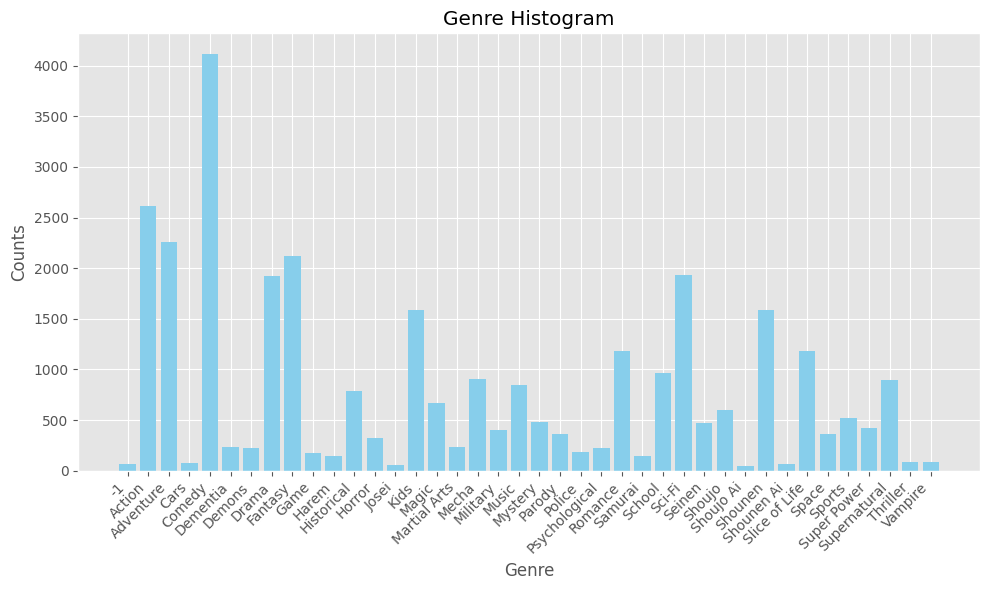

In [116]:
genre_df = raw_df.copy()
genre_df['processed_genre'] = genre_df['genre'].str.split(', ')
genre_df = genre_df.explode('processed_genre')

genre_df['processed_genre'] = genre_df['processed_genre'].fillna('-1') # replace all NaN values
genre, genre_counts = np.unique(genre_df['processed_genre'], return_counts=True)

# Visualize genre histogram
visualize_histogram(genre, genre_counts, 'Genre', 'Counts', 'Genre Histogram')

## 2. Посчитайте и визуализируйте средний рейтинг и стандартное отклонение по типу аниме type. (1 балл)

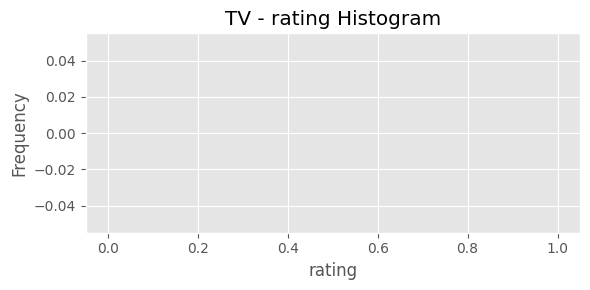

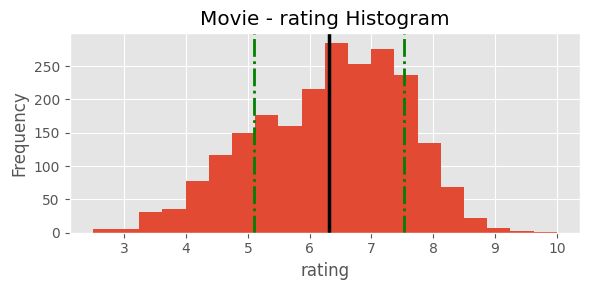

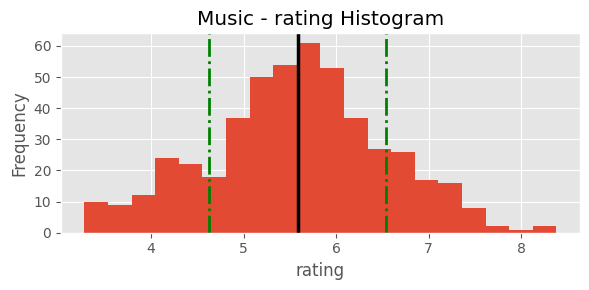

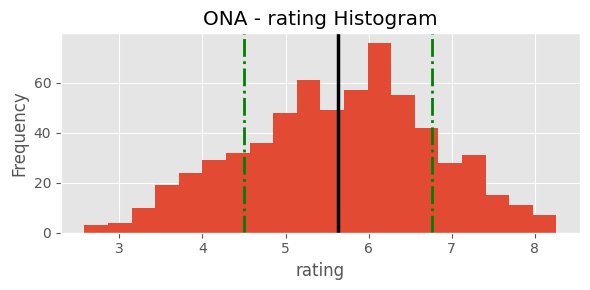

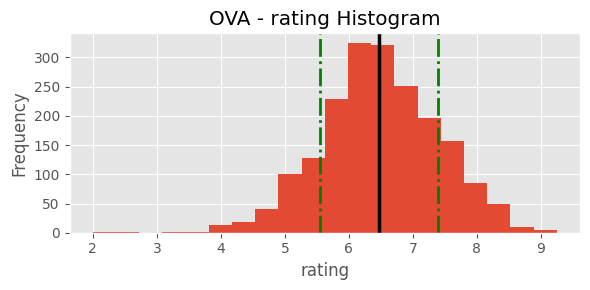

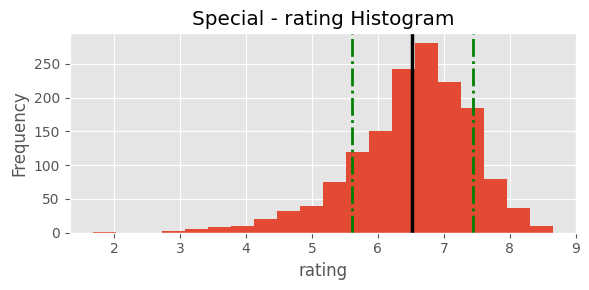

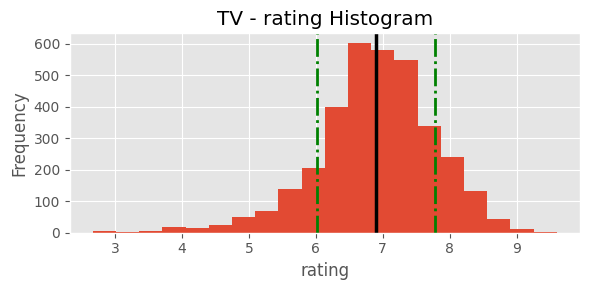

In [76]:
# First, I group the data by Type anime. For each group I calculated the mean and std
# NOTE : first chart with 'TV' title is empty, I didn't figure out why but it should have 'NaN' title, not 'TV'

categorical_col = 'type_categorical'
raw_df[categorical_col] = pd.Categorical(raw_df['type']).codes
groups = raw_df.groupby(categorical_col)

for name, group in groups:
    category_label = pd.Categorical(raw_df['type']).categories[name]

    col = 'rating'
    m = group[col].mean()
    std = group[col].std()

    plt.figure(figsize=(6, 3))
    ax = group[col].plot(kind='hist', bins=20, title=f'{category_label} - {col} Histogram')
    
    ax = plt.axvline(m, c='k', ls='-', lw=2.5)
    ax = plt.axvline(m + std, c='green', ls='-.', lw=2)
    ax = plt.axvline(m - std, c='green', ls='-.', lw=2)


    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.tight_layout()

## 3. Посчитайте и визуализируйте средний рейтинг и стандартное отклонение по жанрам. (1 балл)
График постройте для топ-15 жанров по рейтингу

In [141]:
# 1. Find top 15 genres
first_n_top_genres = 15
rating_of_first_n_top_genres = genre_df.groupby('processed_genre')['rating'].mean().sort_values(ascending=False).head(first_n_top_genres)
top_15_genres, _ = rating_of_first_n_top_genres.index, rating_of_first_n_top_genres.values

# 2. Get rating histogram, mean_rating, std_mean
from collections import defaultdict
genres_with_histogram_and_metrics = defaultdict()
for genre in top_15_genres:
    current_genre_df = genre_df[genre_df['processed_genre'] == genre]
    current_genre_df = current_genre_df[['rating']].dropna() # drop any NaN values to not affect on mean and std
    rating_mean = current_genre_df['rating'].mean()
    rating_std = current_genre_df['rating'].std()
    genres_with_histogram_and_metrics = {
        genre: {
            'rating': current_genre_df['rating'],
            'mean': rating_mean,
            'std': rating_std
        }
    }

# 3. Iterate through genres and visualize the rating histogram and metrics
# TODO

In [142]:
for genre in genres_with_histogram_and_metrics:
    print(genres_with_histogram_and_metrics[genre]['rating'])

88      8.53
214     8.31
260     8.24
307     8.20
325     8.18
        ... 
6673    5.62
6988    5.30
7126    5.13
7136    5.12
9319    5.75
Name: rating, Length: 62, dtype: float64


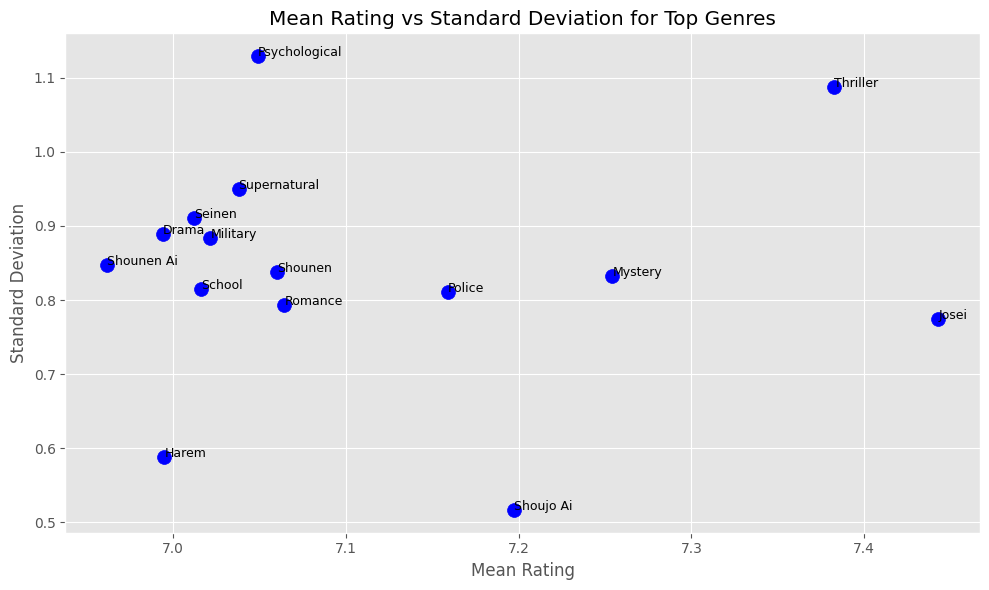

In [64]:
genre_stats = genre_df.groupby('processed_genre')['rating'].agg(['mean', 'std']).reset_index()
top_15_genres_by_rating = genre_stats.sort_values(by='mean', ascending=False).head(15).reset_index(drop=True)
top_15_genres_by_rating


plt.figure(figsize=(10, 6))
plt.scatter(top_15_genres_by_rating['mean'], top_15_genres_by_rating['std'], color='blue', s=100)

for i in range(len(top_15_genres_by_rating)):
    plt.text(top_15_genres_by_rating['mean'][i], top_15_genres_by_rating['std'][i], top_15_genres_by_rating['processed_genre'][i], fontsize=9)

plt.xlabel('Mean Rating')
plt.ylabel('Standard Deviation')
plt.title('Mean Rating vs Standard Deviation for Top Genres')

plt.tight_layout()
plt.show()


## 4. Посчитайте и визуализируйте квартили Q1, Q2 и Q3 с интерквантильным размахом по жанрам genre и типу аниме type. (1 балл)

In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df = raw_df.copy()
df['genre'] = df['genre'].str.split(', ')
df_exploded = df.explode('genre')

# Step 2: Group by 'genre' and 'type', then calculate quartiles and IQR
quartiles = df_exploded.groupby(['genre', 'type'])['rating'].quantile([0.25, 0.5, 0.75]).unstack()
# # Renaming columns for clarity
quartiles.columns = ['Q1', 'Q2', 'Q3']

# # Calculate IQR
quartiles['IQR'] = quartiles['Q3'] - quartiles['Q1']
quartiles

# # Step 3: Reset index to get a flat DataFrame for easier visualization
# quartiles = quartiles.reset_index()

# # Step 4: Visualization using a boxplot for ratings by genre and type
plt.figure(figsize=(12, 8))

# # Seaborn boxplot showing distribution of ratings for each genre and type
# sns.boxplot(x='genre', y='rating', hue='type', data=df_exploded)

# # Add title and labels
# plt.title('Quartiles and IQR of Ratings by Genre and Type')
# plt.xlabel('Genre')
# plt.ylabel('Rating')
# plt.xticks(rotation=90)

# plt.tight_layout()
# plt.show()


Q1     Q2      Q3     IQR
genre   type                                  
Action  Movie    5.9500  6.895  7.5525  1.6025
        Music    6.0600  6.310  6.6600  0.6000
        ONA      5.4500  6.170  7.0000  1.5500
        OVA      6.0000  6.580  7.1800  1.1800
        Special  6.3500  6.890  7.3250  0.9750
...                 ...    ...     ...     ...
Vampire Music    5.2350  5.375  5.5875  0.3525
        ONA      5.1175  5.575  6.4375  1.3200
        OVA      6.9250  7.140  7.4000  0.4750
        Special  6.3775  6.840  7.1600  0.7825
        TV       6.7450  7.160  7.5350  0.7900

[223 rows x 4 columns]

## 5. Насколько часто встречаются аниме с одним или двумя жанрами? (1 балл)

## 6. Сколько в среднем эпизодов приходится на аниме типа == TV? (1 балл)

## 7. По правилу трех сигм на столбцах episodes, rating и members оцените кол-во аномалий. (1 балл)
если по одному из столбцов аниме не попадает в интервал трех сигм, то оно считается аномальным


## 8. Оцените и визуализируйте корреляцию среднего рейтинга жанра со средними кол-вом эпизодов и кол-вом подписчиков. (1 балл)

## 9. Оцените и визуализируйте корреляцию кол-ва жанров у аниме с его рейтингом и кол-вом подписчиков по каждому типу аниме type. (1 балл)

## 10. Оцените и визуализируйте корреляцию длины названия аниме name с его рейтингом, кол-вом жанров, эпизодов и подписчиков. (1 балл)

# 2. Часть

Каждое задание оценивается 1 баллом в случае полного выполнения

 ### Задание 11: Нормальное распределение (1 балл)
Генерация данных \
Сгенерируйте выборку из 1000 элементов с нормальным распределением, где среднее  μ=5 и стандартное отклонение σ=1.5.
Описательная статистика \
Рассчитайте выборочное среднее, выборочную медиану, выборочную моду и стандартное отклонение. \
Графическое представление \
Постройте гистограмму и график плотности распределения. Сравните выборочные статистики с теоретическими. \
Анализ отклонений \
Рассчитайте частоту значений, которые отклоняются от среднего на более чем одно стандартное отклонение, и сравните это с теоретическим результатом для нормального распределения.

### Задание 12: Экспоненциальное распределение (1 балл)
Генерация данных \
Сгенерируйте выборку из 1000 элементов из экспоненциального распределения с параметром λ=0.5. \
Описательная статистика \
Рассчитайте выборочное среднее, медиану и стандартное отклонение. \
Графическое представление \
Постройте гистограмму и график плотности распределения. \
Анализ распределения \
Определите долю значений в выборке, которые больше двух выборочных средних, и сравните это с теоретической вероятностью для экспоненциального распределения. \


### Задание 13: Биномиальное распределение (1 балл)
Генерация данных \
Сгенерируйте выборку из 1000 наблюдений из биномиального распределения с параметрами  n=10 и p=0.7 \
Описательная статистика \
Найдите выборочное среднее, дисперсию и моду количества успехов. \
Графическое представление \
Постройте столбчатую диаграмму распределения количества успехов. \
Анализ вероятностей \
Вычислите вероятность того, что количество успехов будет больше 8, используя как выборочные данные, так и теоретическую вероятность биномиального распределения. Сравните результаты. \

### Задание 14: Геометрическое распределение (1 балл)
Генерация данных \
Сгенерируйте выборку из 1000 наблюдений из геометрического распределения с вероятностью успеха p=0.3. \
Описательная статистика \
Рассчитайте выборочное среднее, медиану и моду количества попыток до первого успеха. \
Графическое представление \
Постройте гистограмму распределения количества попыток. \
Анализ вероятностей \
Определите вероятность того, что потребуется не более 5 попыток для первого успеха, используя как выборочные данные, так и теоретическое геометрическое распределение. Сравните результаты. \

### Задание 15: Равномерное распределение (1 балл)
Генерация данных \
Сгенерируйте выборку из 1000 наблюдений из равномерного распределения на отрезке от 3 до 7. \
Описательная статистика \
Рассчитайте выборочное среднее, медиану и стандартное отклонение. \
Графическое представление  \
Постройте гистограмму и график плотности распределения. Сравните выборочные статистики с теоретическими значениями для равномерного распределения.
Анализ крайних значений \
Определите долю значений, которые находятся ближе к границам распределения (например, больше 6 или меньше 4), и сравните с ожидаемым результатом для равномерного распределения. \

### Задание 16: Распределение Пуассона (1 балл)
Генерация данных \
Сгенерируйте выборку из 1000 наблюдений из распределения Пуассона с параметром  λ=4. \
Описательная статистика \
Найдите выборочное среднее, дисперсию и моду количества событий. \
Графическое представление \
Постройте столбчатую диаграмму распределения количества событий. \
Анализ вероятностей \
Определите вероятность того, что количество событий будет меньше 3, используя как выборочные данные, так и теоретическое распределение Пуассона. Сравните результаты. \

# 3 Часть

## Задание 17: Проверка несмещённости и состоятельности выборочного среднего рейтингов (3 балла все задание)
1. Вычисление генерального среднего рейтингов \
Рассчитайте выборочное среднее рейтингов всех аниме. \
2. Проверка несмещённости оценки выборочного среднего \
Сгенерируйте 1000 выборок объёма n=100 с возвращением из исходных данных.
Для каждой выборки вычислите выборочное среднее рейтингов.
Постройте гистограмму распределения полученных выборочных средних.
Вычислите среднее из выборочных средних и сравните его с генеральным средним исходных данных. Сделайте вывод о несмещенности оценки. (1 балл)
3. Проверка состоятельности оценки выборочного среднего. \
Повторите шаги из пункта 2 для различных объёмов выборки: n=50, 200, 500.
Для каждого объёма выборки вычислите дисперсию выборочных средних.
Постройте график зависимости дисперсии выборочных средних от объёма выборки.
Проанализируйте, как дисперсия уменьшается с увеличением объёма выборки. Сделайте вывод о состоятельности оценки. (1 балл)

## Задание 18: Проверка несмещённости и состоятельности медианы рейтингов (3 балла все задание)
1. Вычисление генеральной медианы \
Рассчитайте медиану рейтингов по всему датасету.
2. Проверка несмещённости медианы \
Сгенерируйте 1000 выборок объёма n=100 с возвращением.
Для каждой выборки вычислите медиану рейтингов.
Постройте гистограмму распределения полученных медиан.
Вычислите среднее из медиан и сравните с медианой исходных данных. Сделайте вывод о несмещенности оценки. (1 балл)
3. Проверка состоятельности медианы \
Повторите шаги из пункта 2 для n=50, 200, 500.
Для каждого объёма выборки вычислите стандартное отклонение медиан.
Постройте график зависимости стандартного отклонения медиан от объёма выборки.
Проанализируйте изменение разброса медиан с ростом объёма выборки. Сделайте вывод о состоятельности оценки. (1 балл)

## Задание 19: Проверка несмещённости и состоятельности выборочной дисперсии рейтингов (3 балла все задание)
1. Вычисление выборочной дисперсии \
Рассчитайте выборочную дисперсию рейтингов по всему датасету.
2. Проверка несмещённости оценки выборочной дисперсии \
Сгенерируйте 1000 выборок объёма n=100 с возвращением.
Для каждой выборки вычислите выборочную дисперсию.
Постройте гистограмму распределения полученных дисперсий.
Вычислите среднее из дисперсий и сравните с выборочной дисперсией исходных данных. Сделайте вывод о несмещенности оценки. (1 балл)
3. Проверка состоятельности оценки выборочной дисперсии \
Повторите шаги из пункта 2 для n=50, 200, 500.
Для каждого объёма выборки вычислите дисперсию оценок выборочной дисперсии.
Постройте график зависимости дисперсии оценок выборочной дисперсии от объёма выборки.
Проанализируйте изменение разброса оценок с ростом объёма выборки.  Сделайте вывод о состоятельности оценки. (1 балл)